# Libraries

In [1]:
import sys
sys.executable

'/home/avgupta/anaconda2/bin/python2'

In [2]:
#import snap
import collections
from collections import namedtuple
import numpy as np
import pdb
import pandas as pd
from sklearn.metrics import mean_squared_error
import copy
import matplotlib.pylab as plt
%matplotlib inline

In [12]:
np.random.seed(3)

# Defining the Ratings Graph Class

In [18]:
Rating = namedtuple('Rating', ['Rating', 'User', 'Object'])

class RatingsGraph:
    def __init__(self, ratings, gold_ratings, alpha):
        self.alpha = alpha
        self.ratings = ratings
        self.gold_ratings = gold_ratings
        
        self.users = set([rating.User for rating in self.ratings])
        self.objects = set([rating.Object for rating in self.ratings])
        
        self.bias_diffs = []
        
        self.user_ratings = collections.defaultdict(list)
        self.object_ratings = collections.defaultdict(list)
        self.user_object_ratings = {}
        
        for rating in self.ratings:
            self.user_ratings[rating.User].append(rating.Object)
            self.object_ratings[rating.Object].append(rating.User)
            self.user_object_ratings[(rating.User, rating.Object)] = rating.Rating
        
        self.biases = {user: np.random.uniform(-1, 1) for user in self.users}
        self.true_ratings = {obj: np.random.uniform(0, 1) for obj in self.objects}        
        
    def get_user_ratings(self, user):
        return self.user_ratings[rating.User]
    
    def get_object_ratings(self, obj):
        return self.object_ratings[obj]
    
    def perform_single_iteration(self):
        converged = True
        
        alpha = self.alpha
        
        max_diff = 0
        
        for obj in self.objects:
            original_rating = self.true_ratings[obj]
            self.true_ratings[obj] = sum([(1.0 / len(self.object_ratings[obj])) * \
                            max(0, (min(1, self.user_object_ratings[(user, obj)]-alpha*self.biases[user])))\
                                    for user in self.object_ratings[obj]])
            if abs(original_rating - self.true_ratings[obj]) > 0.00001:
                if abs(original_rating - self.true_ratings[obj]) > max_diff:
                    max_diff = abs(original_rating - self.true_ratings[obj])
                converged = False
        #print "Ratings Diff: {}".format(max_diff)
            
        bias_diff = 0
        
        for user in self.users: 
            original_bias = self.biases[user]
            self.biases[user] = sum([(1.0 / len(self.user_ratings[user])) * \
                                     (self.user_object_ratings[(user, obj)] - self.true_ratings[obj]) \
                                    for obj in self.user_ratings[user]])
        
            bias_diff += abs(original_bias - self.biases[user])
            
            if abs(original_bias - self.biases[user]) > 0.00001:
                converged = False
                
        #print "Bias Diff: {}".format(np.sum(bias_diff))
        self.bias_diffs.append(bias_diff)
        return converged
    
    def get_test_error(self):
        pred_ratings = [self.true_ratings[obj_id] for obj_id in self.gold_ratings if obj_id in self.true_ratings]
        test_ratings = [self.gold_ratings[obj_id] for obj_id in self.gold_ratings if obj_id in self.true_ratings]
        return mean_squared_error(pred_ratings, test_ratings)
            
    def iterate_until_convergence(self):
        errors = []
        
        converged = False
        while not converged:
            error = self.get_test_error()
            print (error)
            errors.append(error)
            converged = self.perform_single_iteration()
        return errors

In [14]:
def isfloat(value):
    try:
        float(value)
        return True
    except ValueError:
        return False

def get_data_set():
    movie_critic_ratings = {}
    
    movie_header_indeces = {}
    for line in open('data/grouplens/movies.dat'):
        line = line.strip()
        if not movie_header_indeces:
            for i, column in enumerate(line.split('\t')):
                movie_header_indeces[column] = i
            continue
        NUM_TOP_CRITICS_REVIEWS_IDX = movie_header_indeces['rtTopCriticsNumReviews']
        TOP_CRITICS_RATING_IDX = movie_header_indeces['rtTopCriticsRating']
        
        movie_id, critic_rating, num_critic_ratings = line.split()[0], line.split()[TOP_CRITICS_RATING_IDX], line.split()[NUM_TOP_CRITICS_REVIEWS_IDX]
        
        if isfloat(num_critic_ratings) and (num_critic_ratings > 10) and isfloat(critic_rating):
            critic_rating = float(critic_rating) / 10.0
            movie_critic_ratings[movie_id] = critic_rating
        
    user_rating_header_indeces = {}
    ratings = []
    for line in open('data/grouplens/user_ratedmovies.dat'):
        line = line.strip()
        if not user_rating_header_indeces:
            for i, column in enumerate(line.split('\t')):
                user_rating_header_indeces[column] = i
            continue
        
        user_id, movie_id, rating = line.split()[0], line.split()[1], line.split()[2]
        rating = float(rating) / 5.0
        ratings.append(Rating(Rating=rating, User=user_id, Object=movie_id))
    
    return ratings, movie_critic_ratings

ratings, movie_critic_ratings = get_data_set()

In [19]:
ratings_graph = RatingsGraph(ratings, movie_critic_ratings, alpha=0.1)
errors = ratings_graph.iterate_until_convergence()
alpha_01_y = ratings_graph.bias_diffs

62.278483073144336
61.496129439707616
61.493603840106864
61.493138362295305
61.493088210166945


In [20]:
ratings_graph = RatingsGraph(ratings, movie_critic_ratings, alpha=0.2)
errors = ratings_graph.iterate_until_convergence()
alpha_02_y = ratings_graph.bias_diffs

62.133575117621646
61.5042135106929
61.49676115634972
61.4937350885157
61.49310223561717
61.49297770975244


In [21]:
ratings_graph = RatingsGraph(ratings, movie_critic_ratings, alpha=0.5)
errors = ratings_graph.iterate_until_convergence()
alpha_05_y = ratings_graph.bias_diffs

62.2074645052631
61.61746091226952
61.56135313001548
61.5275458176886
61.51039013655257
61.50193470285097
61.497793206880004
61.49576827744867
61.494778754818824
61.49429528989775
61.4940591028989
61.493943719495086
61.49388735141865


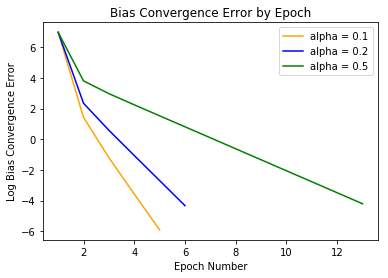

In [22]:
# alpha1_y = [1060.7027209712728, 8.151491760725987, 0.7153737296671119, 0.06850560075491723, 0.006667511431112653]
# alpha2_y = [1070.5935889341972, 4.564030247992877, 0.612904383225149, 0.11645027071102854, 0.022635037211159174, 0.004417496078544927]
# alpha3_y = [1053.1551336990312, 25.10273404110145, 7.154351826286142, 3.1423294052572497, 1.5036110680676322, 0.7318008354801494, 0.35723892532225704, 0.17449089566980958, 0.08524172566812642, 0.041643162313176836, 0.020344054518165375, 0.009938663773250384]

plt.plot([i+1 for i in range(len(alpha_01_y))], [np.log(y) for y in alpha_01_y], 'orange', label='alpha = 0.1')
plt.plot([i+1 for i in range(len(alpha_02_y))], [np.log(y) for y in alpha_02_y], '-b', label='alpha = 0.2')
plt.plot([i+1 for i in range(len(alpha_05_y))], [np.log(y) for y in alpha_05_y], '-g', label='alpha = 0.5')
plt.legend()
plt.title('Bias Convergence Error by Epoch')
plt.xlabel('Epoch Number')
plt.ylabel('Log Bias Convergence Error')

In [ ]:
user_ratings_df = pd.read_table('data/grouplens/user_ratedmovies.dat', sep="\t")
movie_ratings_df = pd.read_table('data/grouplens/movies.dat', sep="\t")